In [1]:
import pandas as pd
import numpy as np
import random
import copy
import torch

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 42

In [3]:
data = pd.read_csv('../../GeneralData/ETTh1.csv')
data

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778000


In [4]:
import torch.nn as nn

In [5]:
feature_size = 7

In [6]:
# LSTM은 Encoder와 Decoder를 각각 구현해야 한다.
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_size = 14
        self.input_size = feature_size
        self.encoder = nn.LSTM(input_size = self.input_size,
                       hidden_size = self.hidden_size,
                       num_layers = 1,
                       batch_first = True).to(device)
        # batch_first = True로 인해서 (batch,seq,feature)순으로 입력 받는다.
        # 그 당시에 알고 있는 정보가 없으므로 input_size = 0
        self.decoder = nn.LSTM(input_size = self.input_size,
                       hidden_size = self.hidden_size,
                       num_layers = 1,
                       batch_first = True).to(device)
        
        
        self.output_layer = nn.Linear(self.hidden_size, 1).to(device)
    def forward(self,x):
        x = x.to(device)
        self.encoder.flatten_parameters()
        self.decoder.flatten_parameters()
        outputs,(hidden,cell) = self.encoder(x)
        
        # 현재 prediction_length = 1이기 때문에, 반복문을 돌리지 않아도 됨
        # but 길어진다면 반복문을 돌려서 output값을 얻어야 한다.
        # 기본적으로 output = hidden state이기에 output을 생성할
        # Fully Connected Layer가 필요하게 된다.
        # 이때 decoder_output의 사이즈는 (batch,seq,hidden) 이다
        # 중간에 seq가 들어오게 되는 이유는 입력 크기 만큼 lstm이 반복되기 때문에
        # seq=1 이기 때문에 squeeze를 수행
        
        hidden = hidden.to(device)
        cell = cell.to(device)
        decoder_input = torch.zeros([x.size(0),1,x.size(2)]).to(device)
        decoder_out,(hidden,cell) = self.decoder(decoder_input,(hidden,cell))
        decoder_out = decoder_out.squeeze(1)
        
        out = self.output_layer(decoder_out)
        
        return out

In [7]:
a = np.array([1,2,3])
a.shape[0]

3

In [8]:
lst = [i for i in range(1,13)]
A = torch.FloatTensor(lst).view(3,2,2)
B = torch.zeros((2,2))
B[0,0] = 1
B[1,1] = 1
A*B # BroadCasting

tensor([[[ 1.,  0.],
         [ 0.,  4.]],

        [[ 5.,  0.],
         [ 0.,  8.]],

        [[ 9.,  0.],
         [ 0., 12.]]])

In [9]:
class Filter(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = LSTM()
    def forward(self,x,train_index_matrix=[]):
        # 2차원 인덱스 리스트가 들어온다.
        # train_index_matrix = 2차원
        # 행은 time 열은 Feature를 의미
        if len(train_index_matrix)==0:
            return self.model(x)
        filters = torch.FloatTensor(np.zeros((x.shape[1],x.shape[2])))
        filters = filters.to(device)
        for i in range(len(train_index_matrix)):
            for train_idx in train_index_matrix[i]:
                filters[train_idx,i] = 1
        x = x*filters
        out = self.model(x)
        return out

In [10]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch

In [11]:
device = torch.device("cuda:0")

In [12]:
sequence_length = 168 # 24*7 1주일
pred_length = 1 # 1시간
split = int(len(data)*0.8)

In [13]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    for i in range(0,len(x)-sequence_length):
        # 시간데이터를 제외하고 추출
        seq_list.append(x.iloc[i:i+sequence_length,1:].values)
        # OT만 추출
        target_list.append(x.iloc[i+sequence_length,-1])
        
    return torch.FloatTensor(seq_list).view(-1,sequence_length,7).to(device), torch.FloatTensor(target_list).view(-1,pred_len,1).to(device)

In [14]:
train = data.iloc[:split]
val = data.iloc[split:]

X_train, y_train = seq_data(train,sequence_length,pred_length)
X_val, y_val = seq_data(val,sequence_length,pred_length)

tr_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val,y_val)

training =  DataLoader(tr_dataset,batch_size = 64)
validation = DataLoader(val_dataset,batch_size = 64)

/tmp/ipykernel_1390185/2507691695.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return torch.FloatTensor(seq_list).view(-1,sequence_length,7).to(device), torch.FloatTensor(target_list).view(-1,pred_len,1).to(device)


In [15]:
torch.cuda.is_available()

True

In [16]:
X_train.size() # 168개의 sequence_length 7개의 Feature

torch.Size([13768, 168, 7])

* 잘 데이터가 구성된 걸 확인 가능

In [17]:
train.iloc[:169]

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...,...
164,2016-07-07 20:00:00,11.119,4.153,7.427,1.919,3.746,1.675,32.922001
165,2016-07-07 21:00:00,10.449,3.282,7.107,1.279,3.594,1.706,33.625999
166,2016-07-07 22:00:00,10.516,3.885,7.356,1.599,3.168,1.675,32.640999
167,2016-07-07 23:00:00,11.855,5.358,8.884,3.198,3.076,1.553,31.586000


In [18]:
X_train

tensor([[[  5.8270,   2.0090,   1.5990,  ...,   4.2030,   1.3400,  30.5310],
         [  5.6930,   2.0760,   1.4920,  ...,   4.1420,   1.3710,  27.7870],
         [  5.1570,   1.7410,   1.2790,  ...,   3.7770,   1.2180,  27.7870],
         ...,
         [ 10.4490,   3.2820,   7.1070,  ...,   3.5940,   1.7060,  33.6260],
         [ 10.5160,   3.8850,   7.3560,  ...,   3.1680,   1.6750,  32.6410],
         [ 11.8550,   5.3580,   8.8840,  ...,   3.0760,   1.5530,  31.5860]],

        [[  5.6930,   2.0760,   1.4920,  ...,   4.1420,   1.3710,  27.7870],
         [  5.1570,   1.7410,   1.2790,  ...,   3.7770,   1.2180,  27.7870],
         [  5.0900,   1.9420,   1.2790,  ...,   3.8070,   1.2790,  25.0440],
         ...,
         [ 10.5160,   3.8850,   7.3560,  ...,   3.1680,   1.6750,  32.6410],
         [ 11.8550,   5.3580,   8.8840,  ...,   3.0760,   1.5530,  31.5860],
         [ 11.8550,   4.7560,   8.8840,  ...,   2.9550,   1.5230,  31.0930]],

        [[  5.1570,   1.7410,   1.2790,  ...

In [19]:
y_train

tensor([[[31.0930]],

        [[30.7420]],

        [[29.3350]],

        ...,

        [[ 4.2910]],

        [[ 6.2610]],

        [[ 3.9390]]], device='cuda:0')

In [20]:
from torch.optim import Adam

In [21]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
model = Filter().to(device)
optimizer = Adam(model.parameters(),lr = 1e-4)
num_epochs = 200
n = len(training)

In [22]:
def MSE(pred,target):
    return torch.mean((pred-target)**2,dim = 0) # reduction까지 취해줌

In [23]:
model.named_parameters

<bound method Module.named_parameters of Filter(
  (model): LSTM(
    (encoder): LSTM(7, 14, batch_first=True)
    (decoder): LSTM(7, 14, batch_first=True)
    (output_layer): Linear(in_features=14, out_features=1, bias=True)
  )
)>

In [24]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
minimal_loss=np.inf
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs)
#         print(outputs.size())
        outputs = outputs.view(-1,1)    
        labels = labels.view(-1,1)
        
        # defining loss
        loss = MSE(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)))
    if (running_loss/n)*100<minimal_loss:
        best_model = copy.deepcopy(model)
        minimal_loss = (running_loss/n)*100
        print("changed")

model = best_model

Epoch [1]/[200] running accumulative loss across all batches: 299.998
changed
Epoch [2]/[200] running accumulative loss across all batches: 293.345
changed
Epoch [3]/[200] running accumulative loss across all batches: 283.591
changed
Epoch [4]/[200] running accumulative loss across all batches: 271.459
changed
Epoch [5]/[200] running accumulative loss across all batches: 258.352
changed
Epoch [6]/[200] running accumulative loss across all batches: 245.469
changed
Epoch [7]/[200] running accumulative loss across all batches: 234.679
changed
Epoch [8]/[200] running accumulative loss across all batches: 225.510
changed
Epoch [9]/[200] running accumulative loss across all batches: 217.436
changed
Epoch [10]/[200] running accumulative loss across all batches: 210.248
changed
Epoch [11]/[200] running accumulative loss across all batches: 203.722
changed
Epoch [12]/[200] running accumulative loss across all batches: 197.630
changed
Epoch [13]/[200] running accumulative loss across all batches

Epoch [106]/[200] running accumulative loss across all batches: 23.435
changed
Epoch [107]/[200] running accumulative loss across all batches: 23.049
changed
Epoch [108]/[200] running accumulative loss across all batches: 22.671
changed
Epoch [109]/[200] running accumulative loss across all batches: 22.301
changed
Epoch [110]/[200] running accumulative loss across all batches: 21.940
changed
Epoch [111]/[200] running accumulative loss across all batches: 21.586
changed
Epoch [112]/[200] running accumulative loss across all batches: 21.239
changed
Epoch [113]/[200] running accumulative loss across all batches: 20.900
changed
Epoch [114]/[200] running accumulative loss across all batches: 20.567
changed
Epoch [115]/[200] running accumulative loss across all batches: 20.242
changed
Epoch [116]/[200] running accumulative loss across all batches: 19.922
changed
Epoch [117]/[200] running accumulative loss across all batches: 19.610
changed
Epoch [118]/[200] running accumulative loss across a

In [25]:
from captum.attr import IntegratedGradients,NoiseTunnel

In [26]:
for val_batch in validation:
    temp_n = val_batch[0].size(0)
    for val in val_batch[0]: # 하나의 배치에 대해서 for문
        val = val.unsqueeze(0) # 
        break
val.size()

torch.Size([1, 168, 7])

## basis와 함수값 그리고 Attribution비교

In [27]:
basis = torch.FloatTensor(np.zeros((1,168,7)))
model(basis)

tensor([[-0.4740]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [28]:
model(val)

tensor([[9.6181]], device='cuda:0', grad_fn=<AddmmBackward0>)

### 위의 두값을 더하면 10.0921 이 나온다

In [29]:
ig = IntegratedGradients(model)
temp = ig.attribute(val)

In [30]:
temp.size()

torch.Size([1, 168, 7])

In [31]:
temp.sum(axis = 1)[0].sum(axis = 0)

tensor(10.0920, device='cuda:0', dtype=torch.float64)

In [32]:
cnt = 0
ig = IntegratedGradients(model)
ig_attr_score = np.zeros((sequence_length,feature_size))
for val_batch in validation:
    temp_n = val_batch[0].size(0)
    for val in val_batch[0]: # 하나의 배치에 대해서 for문
        val = val.unsqueeze(0) # size = [1,168,7] 원래 LSTM은 Batch형태로 들어가야 한다.
        temp = ig.attribute(val).abs()
        # 각 attribution score의 절대값을 합한다.
        # 이로써 각 시간별로 영향도를 구함
        # 이 부분이 abs를 씌우는게 절대적인 영향을 반영하는데에 맞는 것 같다.
        # 이전까진 씌우지 않았음
        temp = temp.squeeze(0)
        temp = temp.to("cpu").detach().numpy()   
        ig_attr_score = ig_attr_score+temp
    cnt = cnt + temp_n
ig_attr_score = ig_attr_score/cnt

In [33]:
ig_attr_score[:,0]

array([4.76296472e-06, 4.37227424e-06, 3.67684168e-06, 3.38948752e-06,
       3.31873047e-06, 3.16661574e-06, 3.01978065e-06, 2.92214858e-06,
       2.83846943e-06, 2.82128122e-06, 2.77979167e-06, 2.81113889e-06,
       2.85657559e-06, 2.92224209e-06, 3.06139821e-06, 3.16193015e-06,
       3.28450455e-06, 3.49521119e-06, 3.57089870e-06, 3.57349198e-06,
       3.58837946e-06, 3.64961783e-06, 3.75352306e-06, 3.72908750e-06,
       3.99175870e-06, 4.13159338e-06, 4.18131613e-06, 4.32523508e-06,
       4.27395780e-06, 4.29421763e-06, 4.40313688e-06, 4.43830342e-06,
       4.64844755e-06, 4.80629759e-06, 4.85356039e-06, 4.96139416e-06,
       4.92141384e-06, 4.94690549e-06, 5.04725060e-06, 5.19269045e-06,
       5.44623325e-06, 5.77012450e-06, 6.18729283e-06, 6.65483595e-06,
       7.05783540e-06, 7.52285504e-06, 7.91089454e-06, 8.12949648e-06,
       8.47820603e-06, 8.89718949e-06, 8.92877616e-06, 9.01225848e-06,
       9.22729847e-06, 9.38297712e-06, 9.50469522e-06, 9.82229882e-06,
      

In [34]:
ig_attr_score.shape

(168, 7)

In [35]:
ig_attr_score

array([[4.76296472e-06, 2.01106441e-06, 3.52043628e-06, ...,
        1.47166368e-06, 1.03521224e-06, 7.92806022e-06],
       [4.37227424e-06, 1.73850980e-06, 3.15445094e-06, ...,
        1.38680616e-06, 1.03969869e-06, 7.84274427e-06],
       [3.67684168e-06, 1.51731608e-06, 2.57571739e-06, ...,
        1.22816959e-06, 1.01010684e-06, 7.60206183e-06],
       ...,
       [1.03335913e-01, 4.62462951e-02, 1.06212940e-01, ...,
        9.36274798e-02, 1.14110420e-02, 3.16014924e-01],
       [2.71093098e-01, 4.67331172e-02, 2.13279166e-01, ...,
        2.81289492e-01, 8.86507880e-02, 3.85072562e-01],
       [9.99779855e-01, 3.21515058e-01, 5.43977077e-01, ...,
        5.94987096e-01, 8.05321141e-02, 7.01018843e+00]])

In [36]:
ig_attr_score[:,0]

array([4.76296472e-06, 4.37227424e-06, 3.67684168e-06, 3.38948752e-06,
       3.31873047e-06, 3.16661574e-06, 3.01978065e-06, 2.92214858e-06,
       2.83846943e-06, 2.82128122e-06, 2.77979167e-06, 2.81113889e-06,
       2.85657559e-06, 2.92224209e-06, 3.06139821e-06, 3.16193015e-06,
       3.28450455e-06, 3.49521119e-06, 3.57089870e-06, 3.57349198e-06,
       3.58837946e-06, 3.64961783e-06, 3.75352306e-06, 3.72908750e-06,
       3.99175870e-06, 4.13159338e-06, 4.18131613e-06, 4.32523508e-06,
       4.27395780e-06, 4.29421763e-06, 4.40313688e-06, 4.43830342e-06,
       4.64844755e-06, 4.80629759e-06, 4.85356039e-06, 4.96139416e-06,
       4.92141384e-06, 4.94690549e-06, 5.04725060e-06, 5.19269045e-06,
       5.44623325e-06, 5.77012450e-06, 6.18729283e-06, 6.65483595e-06,
       7.05783540e-06, 7.52285504e-06, 7.91089454e-06, 8.12949648e-06,
       8.47820603e-06, 8.89718949e-06, 8.92877616e-06, 9.01225848e-06,
       9.22729847e-06, 9.38297712e-06, 9.50469522e-06, 9.82229882e-06,
      

In [37]:
ig_attr_score[:,1]

array([2.01106441e-06, 1.73850980e-06, 1.51731608e-06, 1.39863151e-06,
       1.34285380e-06, 1.34726901e-06, 1.36902741e-06, 1.42822363e-06,
       1.45119828e-06, 1.46172957e-06, 1.51241048e-06, 1.53436276e-06,
       1.56734399e-06, 1.62379348e-06, 1.69840540e-06, 1.70590001e-06,
       1.81051951e-06, 1.89565914e-06, 1.92254866e-06, 1.99916000e-06,
       2.05643536e-06, 2.07536719e-06, 2.10170870e-06, 2.11573931e-06,
       2.08408013e-06, 2.12481277e-06, 2.09852008e-06, 2.07735104e-06,
       2.08766046e-06, 2.07841268e-06, 2.08751233e-06, 2.11465292e-06,
       2.14400297e-06, 2.21185712e-06, 2.29874969e-06, 2.40032681e-06,
       2.48347135e-06, 2.55387664e-06, 2.63735349e-06, 2.73538127e-06,
       2.83846000e-06, 2.99979244e-06, 3.15141025e-06, 3.31858768e-06,
       3.47387730e-06, 3.62691010e-06, 3.77727134e-06, 3.97216275e-06,
       4.13481824e-06, 4.27326982e-06, 4.40921791e-06, 4.46405790e-06,
       4.59214215e-06, 4.78417347e-06, 4.93754946e-06, 5.17976642e-06,
      

### Feature Attribution DF를 쪼개는 코드

## 잘못 수행했을때는 성능 개선이 확실했음을 확인할 수 있음
### -> 시간을 통째로 제거하는 버전

In [38]:
sub_attr_df = []
for cnt,column in enumerate(list(data.columns[1:])):
    attr_df = pd.DataFrame(ig_attr_score[:,0],columns = [column]) # 잘못 수행함
    sub_attr_df.append(attr_df)
sub_attr_df

[         HUFL
 0    0.000005
 1    0.000004
 2    0.000004
 3    0.000003
 4    0.000003
 ..        ...
 163  0.076424
 164  0.087846
 165  0.103336
 166  0.271093
 167  0.999780
 
 [168 rows x 1 columns],
          HULL
 0    0.000005
 1    0.000004
 2    0.000004
 3    0.000003
 4    0.000003
 ..        ...
 163  0.076424
 164  0.087846
 165  0.103336
 166  0.271093
 167  0.999780
 
 [168 rows x 1 columns],
          MUFL
 0    0.000005
 1    0.000004
 2    0.000004
 3    0.000003
 4    0.000003
 ..        ...
 163  0.076424
 164  0.087846
 165  0.103336
 166  0.271093
 167  0.999780
 
 [168 rows x 1 columns],
          MULL
 0    0.000005
 1    0.000004
 2    0.000004
 3    0.000003
 4    0.000003
 ..        ...
 163  0.076424
 164  0.087846
 165  0.103336
 166  0.271093
 167  0.999780
 
 [168 rows x 1 columns],
          LUFL
 0    0.000005
 1    0.000004
 2    0.000004
 3    0.000003
 4    0.000003
 ..        ...
 163  0.076424
 164  0.087846
 165  0.103336
 166  0.271093
 167  0

### 이상치를 제거하는 구간

In [39]:
candidate_sub_attr_df = []
for attr_df in sub_attr_df:
    IQR = 1.5*(attr_df.quantile(0.75)-attr_df.quantile(0.25))
    outlier_max = attr_df.quantile(0.75)+IQR
    outlier_min = attr_df.quantile(0.25)-IQR
    candidate_attr = attr_df[(attr_df>=outlier_min) & (attr_df<=outlier_max)]
    candidate_attr = candidate_attr.dropna()
    candidate_sub_attr_df.append(candidate_attr)
candidate_sub_attr_df

[         HUFL
 0    0.000005
 1    0.000004
 2    0.000004
 3    0.000003
 4    0.000003
 ..        ...
 130  0.000477
 131  0.000526
 132  0.000580
 133  0.000631
 134  0.000696
 
 [135 rows x 1 columns],
          HULL
 0    0.000005
 1    0.000004
 2    0.000004
 3    0.000003
 4    0.000003
 ..        ...
 130  0.000477
 131  0.000526
 132  0.000580
 133  0.000631
 134  0.000696
 
 [135 rows x 1 columns],
          MUFL
 0    0.000005
 1    0.000004
 2    0.000004
 3    0.000003
 4    0.000003
 ..        ...
 130  0.000477
 131  0.000526
 132  0.000580
 133  0.000631
 134  0.000696
 
 [135 rows x 1 columns],
          MULL
 0    0.000005
 1    0.000004
 2    0.000004
 3    0.000003
 4    0.000003
 ..        ...
 130  0.000477
 131  0.000526
 132  0.000580
 133  0.000631
 134  0.000696
 
 [135 rows x 1 columns],
          LUFL
 0    0.000005
 1    0.000004
 2    0.000004
 3    0.000003
 4    0.000003
 ..        ...
 130  0.000477
 131  0.000526
 132  0.000580
 133  0.000631
 134  0

In [40]:
import matplotlib.pyplot as plt

[         attr
 0    0.002861
 1    0.002297
 2    0.001294
 3    0.000880
 4    0.000778
 ..        ...
 130  0.684154
 131  0.754501
 132  0.832512
 133  0.906671
 134  1.000000
 
 [135 rows x 1 columns],
          attr
 0    0.002861
 1    0.002297
 2    0.001294
 3    0.000880
 4    0.000778
 ..        ...
 130  0.684154
 131  0.754501
 132  0.832512
 133  0.906671
 134  1.000000
 
 [135 rows x 1 columns],
          attr
 0    0.002861
 1    0.002297
 2    0.001294
 3    0.000880
 4    0.000778
 ..        ...
 130  0.684154
 131  0.754501
 132  0.832512
 133  0.906671
 134  1.000000
 
 [135 rows x 1 columns],
          attr
 0    0.002861
 1    0.002297
 2    0.001294
 3    0.000880
 4    0.000778
 ..        ...
 130  0.684154
 131  0.754501
 132  0.832512
 133  0.906671
 134  1.000000
 
 [135 rows x 1 columns],
          attr
 0    0.002861
 1    0.002297
 2    0.001294
 3    0.000880
 4    0.000778
 ..        ...
 130  0.684154
 131  0.754501
 132  0.832512
 133  0.906671
 134  1

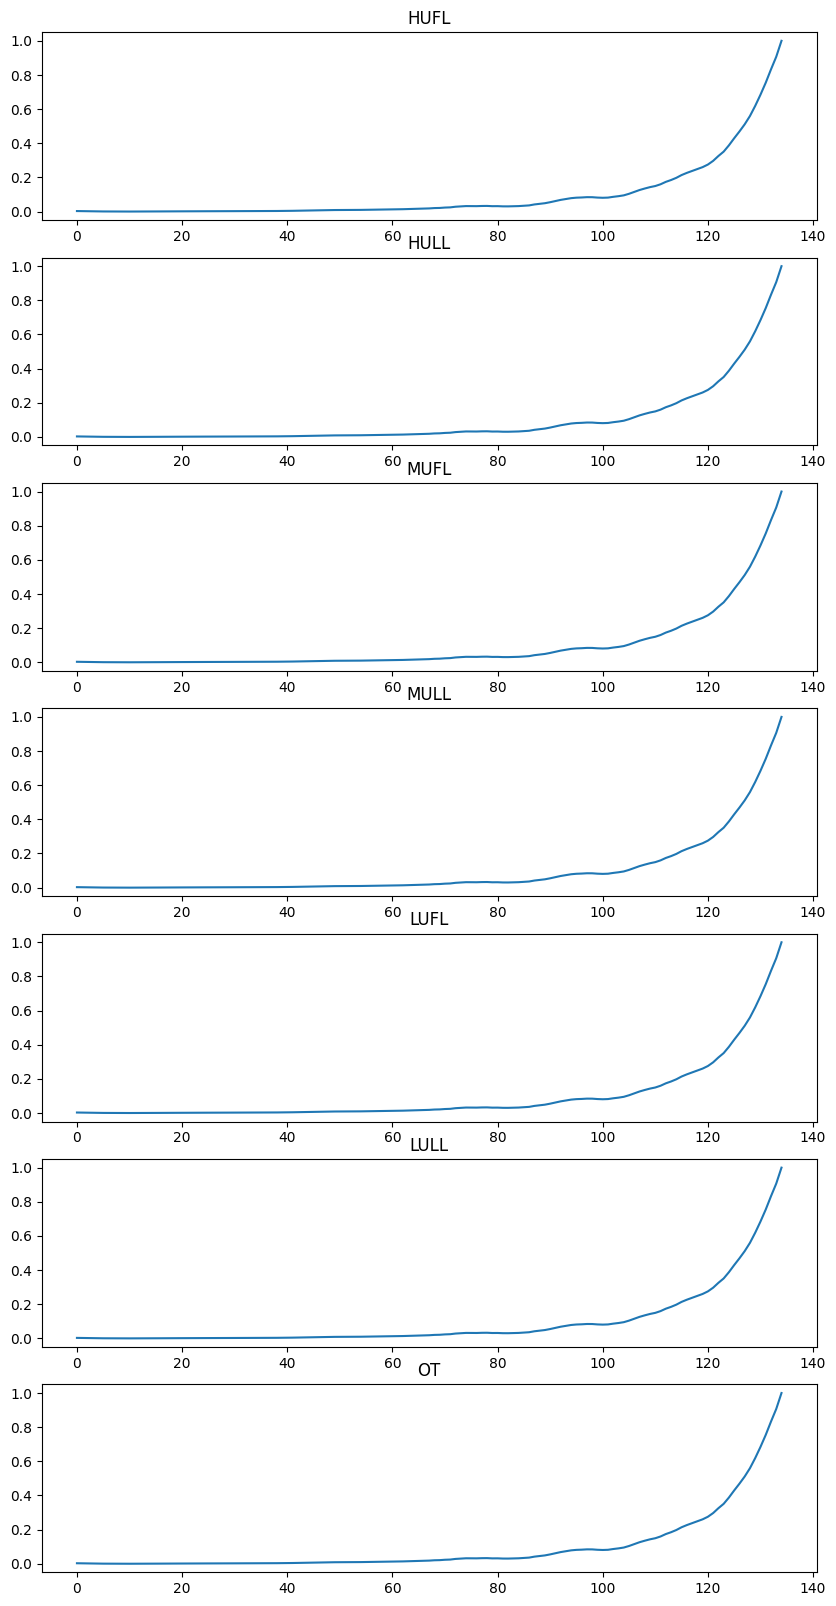

In [41]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
filtering_attr_list = [] # scaling한 attribution dataframe을 저장
fig,ax = plt.subplots(7,1,figsize = (10,20))
for cnt,candidate_attr in enumerate(candidate_sub_attr_df):
    scaler = MinMaxScaler()
    scaler.fit(candidate_attr.values)
    m_attr_df = scaler.transform(candidate_attr.values)
    m_attr_df = pd.DataFrame({"attr":m_attr_df.reshape(-1)})
    filtering_attr_list.append(m_attr_df)
    ax[cnt].plot(m_attr_df)
    ax[cnt].set_title(candidate_attr.columns.item())
filtering_attr_list

In [42]:
total_index_list = [] # train할 index를 저장해두는 리스트이다.
for hyper_para in np.arange(0.00,1.00,0.01):
    index_list = []
    # filtering index를 만든다.
    for m_attr_df in filtering_attr_list:
        append_idx = list(m_attr_df[(m_attr_df['attr']>=hyper_para)].index)
        index_list.append(append_idx)
    total_index_list.append(index_list)
len(total_index_list) 

100

In [43]:
from pytorch_forecasting.metrics import SMAPE,MAE,RMSE

In [ ]:
### 원래 난수가 선언된 위치
m = len(validation)
n = len(training)
cnt = 0
num_epochs = 100
mse_out_list = []
mae_out_list = []
smape_out_list = []
rmse_out_list = []
for sub_index_list in total_index_list: #0.01~1.00 100개의 index에 대해서 수행
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
    train_idx = sub_index_list
    minimal_loss=np.inf
    model = Filter().to(device) # 모델 초기화
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # optimizer 초기화
    result = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in training:
            # forward pass
            inputs = inputs
            
            outputs = model(inputs,train_idx)
            outputs = outputs.view(-1,1)
            labels = labels.view(-1,1)            
            # defining loss
            loss = MSE(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch == 99:    
            print(f'{cnt}번째 모델 Training 완료 마지막 Epoch loss:{(running_loss/n)*100}')
        
        if (running_loss/n)*100<minimal_loss:
            best_model = copy.deepcopy(model)
            minimal_loss = (running_loss/n)*100
            print("changed")

    model = best_model
    cnt+=1
    # 모델 Fully-Training 완료
    
    pred = torch.FloatTensor().to(device)
    val_target = torch.FloatTensor().to(device)
    for val_x,val_y in validation:
        tmp_pred = model(val_x)
        pred = torch.concat([pred,tmp_pred], dim=0)
        val_target = torch.concat([val_target,val_y],dim = 0)
    pred = pred.view(-1,1)
    val_target = val_target.view(-1,1)
    result = MSE(pred,val_target).item()
    mse_out_list.append(result)
    mae_out_list.append(MAE()(pred,val_target).item())
    rmse_out_list.append(RMSE()(pred,val_target).item())
    smape_out_list.append(SMAPE()(pred,val_target).item()*100)

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed


In [50]:
len(mse_out_list)

100

In [55]:
np.array(mse_out_list).min()

16.060270309448242

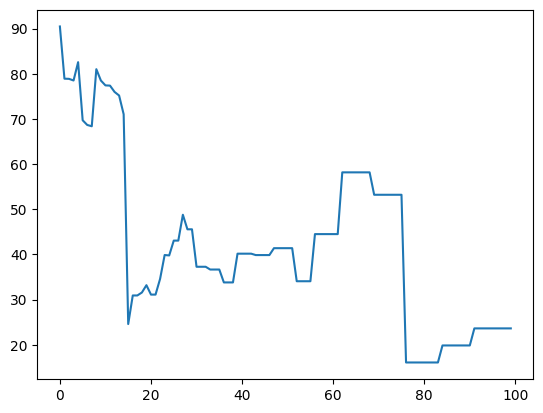

In [51]:
plt.plot(mse_out_list)

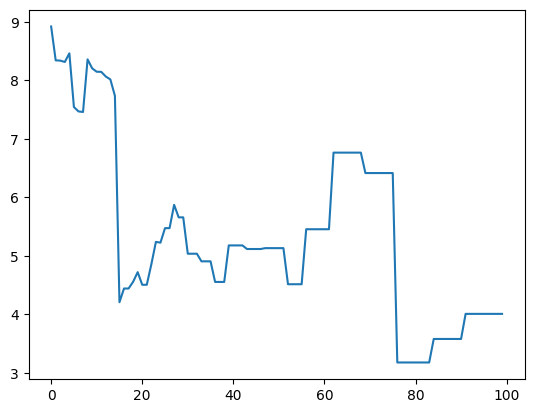

In [52]:
plt.plot(mae_out_list)

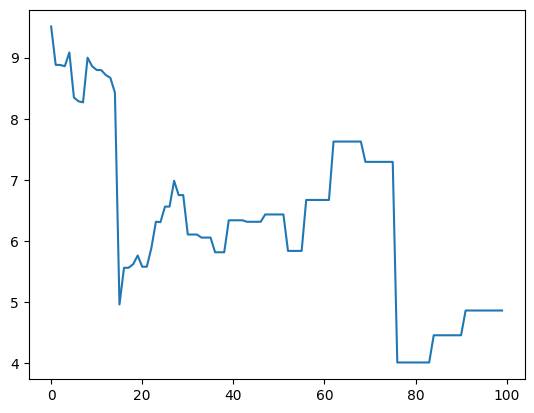

In [53]:
plt.plot(rmse_out_list)

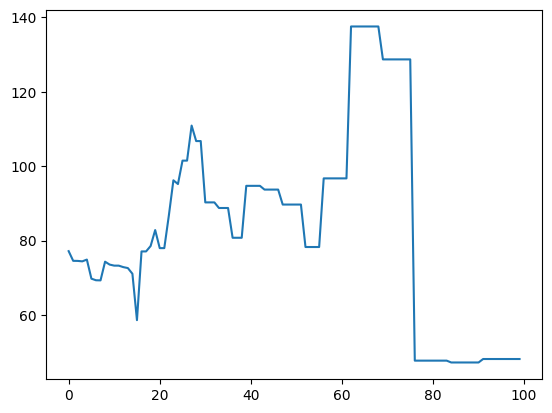

In [54]:
plt.plot(smape_out_list)